# eda.ipynb<br>
作者：艾宏峰<br>
创建时间：2020.10.19<br>
修改时间：2020.10.22<br>

EDA：<br>
1. 数据展示<br>
2. 描述性统计<br>
3. 特征相关性分析<br>
4. 异常样本检测<br>
5. 缺失值检测<br>
6. 重复样本检测<br>
7. 其他针对性研究<br>

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
import math
from tqdm import tqdm
import seaborn as sns
import palettable
import datetime
import warnings
warnings.filterwarnings('ignore')

## 1. 数据展示

|字段|                    类型 |      说明|
|--|--|--|
|QUEUE_ID|               INT  |     队列标识，每个ID代表一个唯一的队列|
|CU|                    INT   |    队列规格，不同规格的资源大小不一样。1CU为1核4GB|
|STATUS|                STRING|    队列状态，当前队列的状态是否可用|
|QUEUE_TYPE|            STRING|    队列类型，不同类型适用于不同的任务，常见的有通用队列（general）和SQL队列|
|PLATFORM|              STRING|    队列平台，创建队列的机器平台|
|CPU_USAGE|             INT   |    CPU使用率，集群中各机器节点的CPU平均使用率|
|MEM_USAGE|             INT   |    内存使用率，集群中各机器节点的内存平均使用率|
|LAUNCHING_JOB_NUMS|    INT   |    提交中的作业数，即正在等待执行的作业|
|RUNNING_JOB_NUMS|      INT   |    运行中的作业数|
|SUCCEED_JOB_NUMS|      INT   |    已完成的作业数|
|CANCELLED_JOB_NUMS|    INT   |    已取消的作业数|
|FAILED_JOB_NUMS|       INT   |    已失败的作业数|
|DOTTING_TIME|          BIGINT|    采集时间，每5分钟进行一次采集|
|RESOURCE_TYPE|         STRING|    资源类型，创建队列的机器类型|
|DISK_USAGE|            INT   |    磁盘使用|

In [2]:
# 载入数据
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/evaluation_public.csv")

In [3]:
print("训练集部分数据展示：")
display(train.head())
print("测试集部分数据展示：")
display(test.head(10))

训练集部分数据展示：


,QUEUE_ID,CU,STATUS,QUEUE_TYPE,PLATFORM,CPU_USAGE,MEM_USAGE,LAUNCHING_JOB_NUMS,RUNNING_JOB_NUMS,SUCCEED_JOB_NUMS,CANCELLED_JOB_NUMS,FAILED_JOB_NUMS,DOTTING_TIME,RESOURCE_TYPE,DISK_USAGE
0,298,16,available,sql,x86_64,0,0,0,0,4,0,0,1582548540000,NaN,NaN
1,298,16,available,sql,x86_64,0,0,0,0,4,0,0,1582548840000,NaN,NaN
2,21671,256,available,sql,x86_64,0,0,0,0,0,0,1,1582549500000,NaN,NaN
3,21671,256,available,sql,x86_64,0,0,0,0,4,0,0,1582549500000,NaN,NaN
4,297,16,available,sql,x86_64,0,0,0,0,7,0,0,1582549500000,NaN,NaN


测试集部分数据展示：


,ID,QUEUE_ID,CU,STATUS,QUEUE_TYPE,PLATFORM,CPU_USAGE,MEM_USAGE,LAUNCHING_JOB_NUMS,RUNNING_JOB_NUMS,SUCCEED_JOB_NUMS,CANCELLED_JOB_NUMS,FAILED_JOB_NUMS,DOTTING_TIME,RESOURCE_TYPE,DISK_USAGE
0,1,297,16,available,sql,x86_64,60,69,0,5,5,0,0,1662213420000,vm,9
1,1,297,16,available,sql,x86_64,58,69,0,9,4,0,0,1662213720000,vm,9
2,1,297,16,available,sql,x86_64,80,67,0,9,1,0,0,1662214020000,vm,9
3,1,297,16,available,sql,x86_64,100,65,0,7,2,0,1,1662214320000,vm,9
4,1,297,16,available,sql,x86_64,98,67,0,10,3,0,1,1662214620000,vm,9
5,2,85153,64,available,general,x86_64,56,91,0,0,0,0,0,1613655960000,vm,20
6,2,85153,64,available,general,x86_64,48,78,0,1,1,0,0,1613656260000,vm,20
7,2,85153,64,available,general,x86_64,23,35,0,0,0,0,0,1613656560000,vm,20
8,2,85153,64,available,general,x86_64,68,61,0,0,0,0,0,1613656860000,vm,20
9,2,85153,64,available,general,x86_64,38,74,0,0,0,0,0,1613657160000,vm,20


## 2. 描述性统计

In [3]:
# 结合官网说明和数据展示，总结出类别型变量名, 连续型变量名和时间序列变量名
contvar_names = ['CPU_USAGE', 'MEM_USAGE', 'LAUNCHING_JOB_NUMS', 'RUNNING_JOB_NUMS', 'SUCCEED_JOB_NUMS', 'CANCELLED_JOB_NUMS', 'FAILED_JOB_NUMS', 'DISK_USAGE']
catvar_names = ['CU', 'STATUS', 'QUEUE_TYPE', 'PLATFORM', 'RESOURCE_TYPE']
timevar_names = ['DOTTING_TIME']

训练集：
样本数量: 501730
变量数量（包括因变量）: 15
连续型变量 (类型、平均数、极值):


,类型,平均值,最小值,最大值
CPU_USAGE,int64,6.104905,0.0,100.0
MEM_USAGE,int64,41.480099,0.0,100.0
LAUNCHING_JOB_NUMS,int64,0.149975,0.0,149.0
RUNNING_JOB_NUMS,int64,0.928302,0.0,71.0
SUCCEED_JOB_NUMS,int64,3.154649,0.0,659.0
CANCELLED_JOB_NUMS,int64,0.010745,0.0,99.0
FAILED_JOB_NUMS,int64,0.052815,0.0,74.0
DISK_USAGE,float64,19.408158,NaN,NaN


类别型变量(类型、数量)：


,类型,数量,unique_cats
CU,int64,10,"[1024, 112, 128, 16, 256, 32, 48, 512, 64, 960]"
STATUS,object,4,"[assigned, assigning, available, suspended]"
QUEUE_TYPE,object,3,"[general, spark, sql]"
PLATFORM,object,2,"[aarch64, x86_64]"
RESOURCE_TYPE,object,3,"[container, nan, vm]"


连续型变量分布直方图：


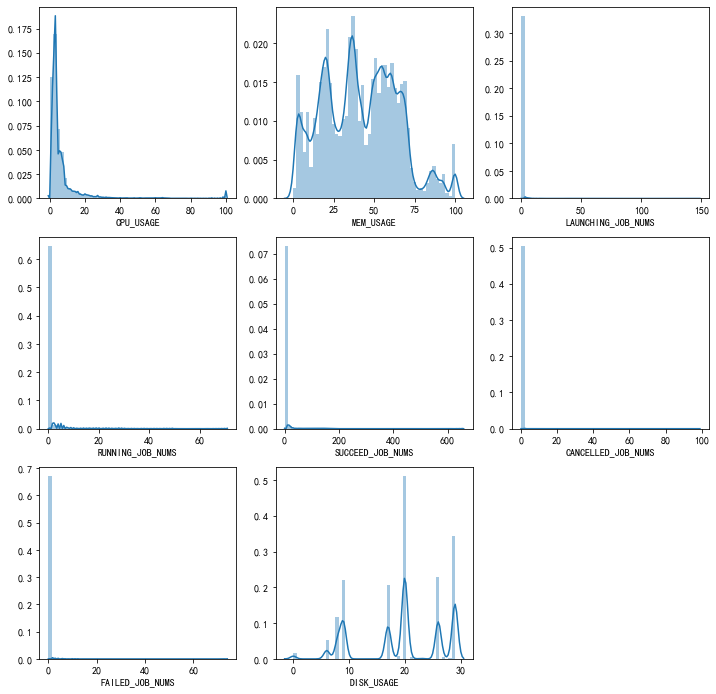

类别型变量分布直方图：


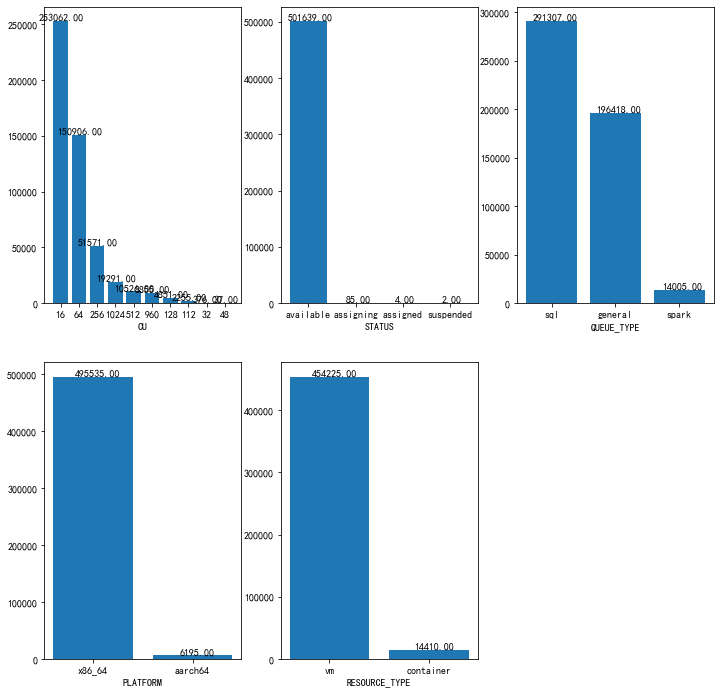

测试集：
样本数量: 14980
变量数量（包括因变量）: 16
连续型变量 (类型、平均数、极值):


,类型,平均值,最小值,最大值
CPU_USAGE,int64,20.741589,0,100
MEM_USAGE,int64,55.457009,2,99
LAUNCHING_JOB_NUMS,int64,1.769092,0,200
RUNNING_JOB_NUMS,int64,4.519559,0,49
SUCCEED_JOB_NUMS,int64,9.444860,0,565
CANCELLED_JOB_NUMS,int64,0.111415,0,195
FAILED_JOB_NUMS,int64,0.361081,0,47
DISK_USAGE,int64,17.816088,8,29


类别型变量(类型、数量)：


,类型,数量,unique_cats
CU,int64,6,"[1024, 16, 256, 512, 64, 960]"
STATUS,object,1,[available]
QUEUE_TYPE,object,2,"[general, sql]"
PLATFORM,object,1,[x86_64]
RESOURCE_TYPE,object,1,[vm]


连续型变量分布直方图：


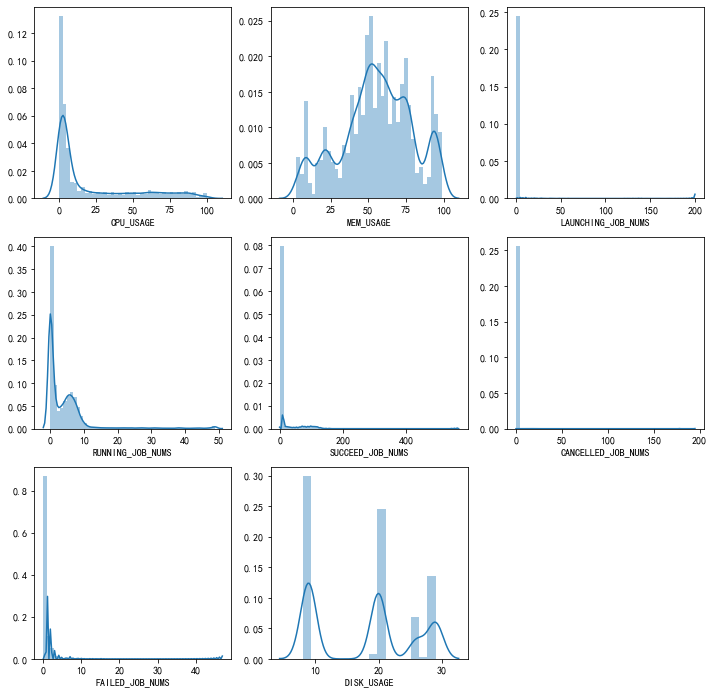

类别型变量分布直方图：


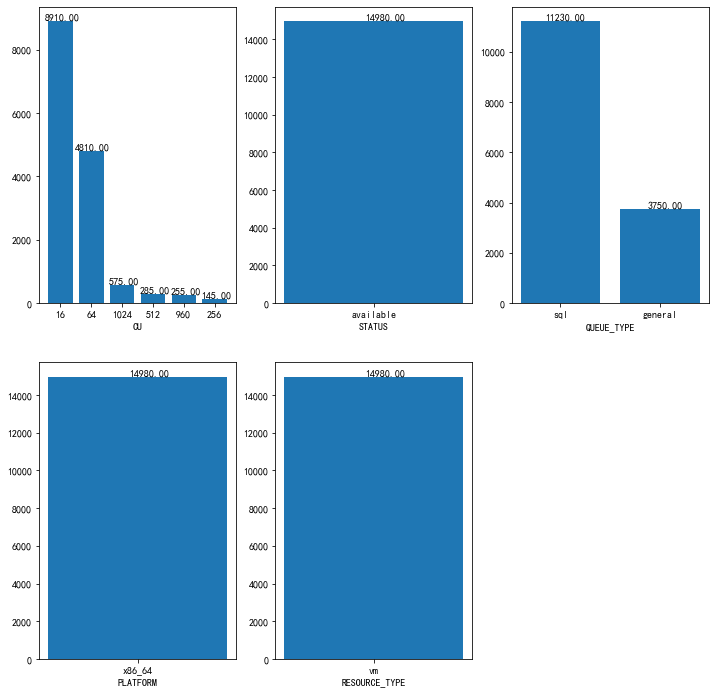

In [8]:
def stat_analysis(data, cont_var_names, cat_var_names):
    '''
    参数：
        1. data           (pd.DataFrame): 输入数据源。
        2. cont_var_names (list)        : 连续型变量们的名字。
        3. cat_var_names  (list)        : 类别型变量们的名字。
    '''  
    # 样本数量、变量数量
    sample_num, var_num = data.shape
    print("样本数量: %d" % sample_num)
    print("变量数量（包括因变量）: %d" % var_num)


    # 连续型变量 (类型、平均数、极值)
    print("连续型变量 (类型、平均数、极值):")
    temp_dict = {"类型":[], "平均值":[], "最小值":[], "最大值":[]}
    names = []
    for cont_var_name in cont_var_names:
        names.append(cont_var_name)
        temp_dict["类型"].append(data.dtypes[cont_var_name])
        temp_dict["平均值"].append(np.mean(data[cont_var_name]))
        temp_dict["最小值"].append(min(data[cont_var_name]))
        temp_dict["最大值"].append(max(data[cont_var_name]))
    cont_df = pd.DataFrame(temp_dict, index = names)
    display(cont_df)
    
    # 类别型变量：数量
    print("类别型变量(类型、数量)：")
    temp_dict = {"类型":[], "数量":[], "unique_cats":[]}
    names = []
    for cat_var_name in cat_var_names:
        names.append(cat_var_name)
        temp_dict["类型"].append(data.dtypes[cat_var_name])
        temp_dict["数量"].append(len(np.unique(data[cat_var_name].astype(str))))
        temp_dict["unique_cats"].append(np.unique(data[cat_var_name].astype(str)))
    cat_df = pd.DataFrame(temp_dict, index = names)
    display(cat_df)
    
    # 变量分布图
    print("连续型变量分布直方图：")
    display_num = len(cont_var_names)
    display_var_names = cont_var_names
    col_num = 3
    row_num = math.ceil(display_num / col_num)
    fig = plt.figure(figsize = (12,12))
    for i in range(1, display_num + 1):
        plt.subplot(row_num, col_num, i)
        sns.distplot(data[data[display_var_names[i-1]].notnull()][display_var_names[i-1]])
    plt.show()

    print("类别型变量分布直方图：")
    display_num = len(cat_var_names)
    display_var_names = cat_var_names
    col_num = 3
    row_num = math.ceil(display_num / col_num)
    fig = plt.figure(figsize = (12,12))
    for i in range(1, display_num + 1):
        plt.subplot(row_num, col_num, i)
        x = list(data[display_var_names[i-1]].value_counts().index)
        y = list(data[display_var_names[i-1]].value_counts().values)
        plt.bar(range(len(x)), y)
        plt.xticks(range(len(x)), [str(v) for v in x])
        plt.xlabel(display_var_names[i-1])
        for x_loc, y_loc in zip(range(len(x)), y):
            plt.text(float(x_loc)+0.05, float(y_loc)+0.05,'%.2f' % float(y_loc), ha='center',va='bottom')
    plt.show()
    
print("训练集：")
stat_analysis(train, contvar_names, catvar_names)
print("测试集：")
stat_analysis(test, contvar_names, catvar_names)

## 3. 特征相关性分析

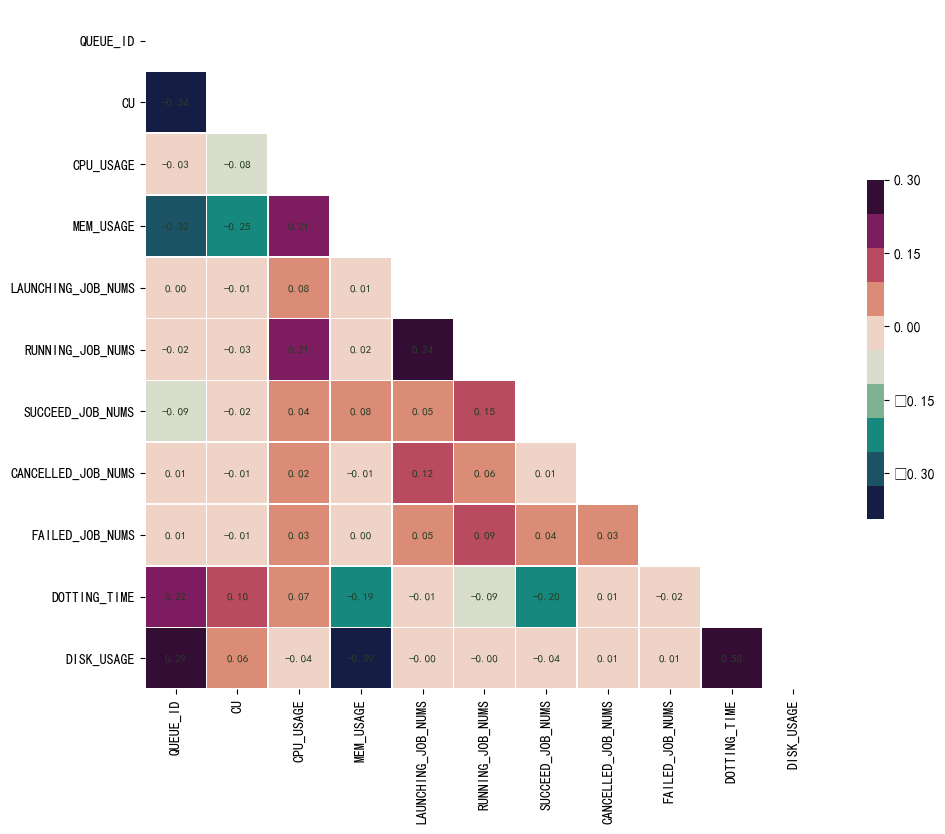

In [19]:
# corr函数计算相关性矩阵(correlation matrix)
train_corr = train.corr(method='pearson')
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data=train_corr,
            vmax=0.3, 
            cmap=palettable.cmocean.diverging.Curl_10.mpl_colors,
            annot=True,
            fmt=".2f",
            annot_kws={'size':8, 'weight':'normal', 'color':'#253D24'},
            mask=np.triu(np.ones_like(train_corr,dtype=np.bool)),#显示对脚线下面部分图
            square=True, linewidths=.5,#每个方格外框显示，外框宽度设置
            cbar_kws={"shrink": .5}
           )
plt.show()

## 4. 异常样本检测

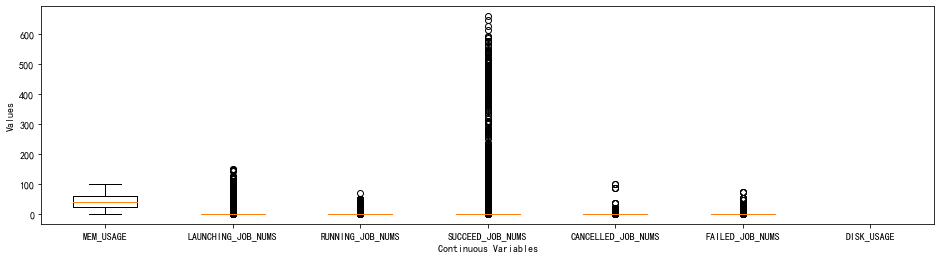

In [17]:
# 从具体数值上，观察异常样本情况
# 绘制箱须图
def boxplot(data, cont_var_names):
    '''只对连续性变量画箱须图'''
    fig = plt.figure(figsize = (16, 4))
    x = [train[i] for i in contvar_names]
    labs = cont_var_names
    plt.boxplot(x[1:], labels=labs[1:]) # 这里地方除掉了time_point这个变量
    plt.xlabel("Continuous Variables")
    plt.ylabel("Values")
    plt.show()

boxplot(train, contvar_names)

## 5. 缺失值检测

In [18]:
def cal_miss_info(data):
    miss_count = data.isnull().sum().sort_values(ascending=False)
    miss_pert = miss_count / len(data)
    miss_info = pd.concat([miss_count, miss_pert], axis=1, keys=["缺失计数", "缺失百分比"])
    print(miss_info)
print("===============\n训练集：\n===============")
cal_miss_info(train)
print("===============\n测试集：\n===============")
cal_miss_info(test)

训练集：
                     缺失计数     缺失百分比
DISK_USAGE          33095  0.065962
RESOURCE_TYPE       33095  0.065962
DOTTING_TIME            0  0.000000
FAILED_JOB_NUMS         0  0.000000
CANCELLED_JOB_NUMS      0  0.000000
SUCCEED_JOB_NUMS        0  0.000000
RUNNING_JOB_NUMS        0  0.000000
LAUNCHING_JOB_NUMS      0  0.000000
MEM_USAGE               0  0.000000
CPU_USAGE               0  0.000000
PLATFORM                0  0.000000
QUEUE_TYPE              0  0.000000
STATUS                  0  0.000000
CU                      0  0.000000
QUEUE_ID                0  0.000000
测试集：
                    缺失计数  缺失百分比
DISK_USAGE             0    0.0
RESOURCE_TYPE          0    0.0
DOTTING_TIME           0    0.0
FAILED_JOB_NUMS        0    0.0
CANCELLED_JOB_NUMS     0    0.0
SUCCEED_JOB_NUMS       0    0.0
RUNNING_JOB_NUMS       0    0.0
LAUNCHING_JOB_NUMS     0    0.0
MEM_USAGE              0    0.0
CPU_USAGE              0    0.0
PLATFORM               0    0.0
QUEUE_TYPE             0    0.

In [44]:
# 查看DISK_USAGE和RESOURCE_TYPE下，缺失数据都集中在哪些队列？
du_miss_qids = np.unique(new_train[new_train['DISK_USAGE'].isnull()]['QUEUE_ID'])
rt_miss_qids = np.unique(new_train[new_train['RESOURCE_TYPE'].isnull()]['QUEUE_ID'])
print("缺失的DISK_USAGE集中在哪些队列：", du_miss_qids)
print("缺失的RESOURCE_TYPE集中在哪些队列：", rt_miss_qids)

缺失的DISK_USAGE集中在哪些队列： [  297   298 20889 21487 21671 21673 81221 82695 82697 82929 83109 83609]
缺失的RESOURCE_TYPE集中在哪些队列： [  297   298 20889 21487 21671 21673 81221 82695 82697 82929 83109 83609]


此外，我对比了下DISK_USAGE和RESOURCE_TYPE，它们是同时缺失的。

## 6. 重复样本检测

In [29]:
def duplicate_det(data):
    if data.duplicated(subset=['QUEUE_ID', 'CU', 'DOTTING_TIME']).any() != True:
        print("无重复无样本")
    else:
        print("有重复样本")
        print("重复样本数量:", len(data[data.duplicated(subset=['QUEUE_ID', 'CU', 'DOTTING_TIME'])]))
print("===============\n训练集：\n===============")
duplicate_det(train)
print("===============\n测试集：\n===============")
duplicate_det(test)

训练集：
有重复样本
重复样本数量: 13586
测试集：
无重复无样本


## 7. 其他研究
(1) 相同QUEUE_ID下，CU、STATUS、QUEUE_TYPE、PLATFORM、RESOURCE_TYPE都一致吗?<br>
(2) 将DOTTING_TIME原格式转为UNIX时间格式，查看有无数据异常情况？<br>
(3) 相同QUEUE_ID下，DOTTING_TIME是完美间隔排序的吗？还是存在数据缺失？<br>
(4) 抽样观察下某些重复样本相邻正常样本的数据状态，看能不能发现样本重复的原因，或有没有较好的预处理方式？<br>

#### (1) 相同QUEUE_ID下，CU、STATUS、QUEUE_TYPE、PLATFORM、RESOURCE_TYPE都一致吗?

In [34]:
def study_qid2cu(data, data_type):
    qids = []
    cus = []
    unique_qids = np.unique(data['QUEUE_ID'])
    for qid in tqdm(unique_qids):
        qids.append(qid)
        tmp_cus = []
        for i in range(len(data)):
            QID = data['QUEUE_ID'][i]
            CU = data['CU'][i]
            if QID == qid and CU not in tmp_cus:
                tmp_cus.append(CU)
        cus.append(tmp_cus)
    qid2cu_df = pd.DataFrame({'QUEUE_ID':qids, 'CU':cus}) 
    print("在%s中，相同QUEUE_ID下，都有哪些CU：" % data_type)
    print(qid2cu_df)
    
study_qid2cu(train, 'train')
study_qid2cu(test, 'test')   

  0%|          | 0/23 [00:00<?, ?it/s]

在train中，相同QUEUE_ID下，都有哪些CU：
    QUEUE_ID                          CU
0          2                        [16]
1          3                        [16]
2          4                        [16]
3         26                      [1024]
4         27                       [512]
5         36                        [16]
6        233                        [16]
7        281                        [64]
8        287                        [16]
9        291                      [1024]
10       293                       [960]
11       297                        [16]
12       298                        [16]
13     20889                        [64]
14     21487                        [64]
15     21671                       [256]
16     21673                        [64]
17     21825                       [256]
18     81221                        [16]
19     82695                        [16]
20     82697                        [16]
21     82929                        [64]
22     83109                 

100%|██████████| 23/23 [00:05<00:00,  4.46it/s]

在test中，相同QUEUE_ID下，都有哪些CU：
    QUEUE_ID      CU
0          2    [16]
1          3    [16]
2          4    [16]
3         26  [1024]
4         27   [512]
5         36    [16]
6        233    [16]
7        281    [64]
8        287    [16]
9        291  [1024]
10       293   [960]
11       297    [16]
12       298    [16]
13     21487    [64]
14     21671   [256]
15     21673    [64]
16     81221    [16]
17     83609    [16]
18     85101    [64]
19     85153    [64]
20     85265    [64]
21     85693    [16]
22     85933    [16]


In [6]:
# 查看下85977队列下，“存在单一队列下有不同的队列规格”这一情况的具体详情
train[train['QUEUE_ID']==85977]['CU'].value_counts()

128    4851
112    2255
16     1271
32      376
48       37
64        3
Name: CU, dtype: int64

In [4]:
catvar_names = ['CU', 'STATUS', 'QUEUE_TYPE', 'PLATFORM', 'RESOURCE_TYPE']
def study_qid2cu(data, data_type):
    qids = []
    cus = []
    unique_qids = np.unique(data['QUEUE_ID'])
    for qid in tqdm(unique_qids):
        qids.append(qid)
        tmp_cus = []
        for i in range(len(data)):
            QID = data['QUEUE_ID'][i]
            CU = data['STATUS'][i]
            if QID == qid and CU not in tmp_cus:
                tmp_cus.append(CU)
        cus.append(tmp_cus)
    qid2cu_df = pd.DataFrame({'QUEUE_ID':qids, 'STATUS':cus}) 
    print("在%s中，相同QUEUE_ID下，都有哪些STATUS：" % data_type)
    print(qid2cu_df)
    
study_qid2cu(train, 'train')
study_qid2cu(test, 'test')  

  0%|          | 0/23 [00:00<?, ?it/s]

在train中，相同QUEUE_ID下，都有哪些STATUS：
    QUEUE_ID                                       STATUS
0          2                                  [available]
1          3                                  [available]
2          4                                  [available]
3         26                                  [available]
4         27                                  [available]
5         36                                  [available]
6        233                                  [available]
7        281                                  [available]
8        287                                  [available]
9        291                                  [available]
10       293                                  [available]
11       297                                  [available]
12       298                                  [available]
13     20889             [assigning, available, assigned]
14     21487                                  [available]
15     21671                            

100%|██████████| 23/23 [00:04<00:00,  5.53it/s]

在test中，相同QUEUE_ID下，都有哪些STATUS：
    QUEUE_ID       STATUS
0          2  [available]
1          3  [available]
2          4  [available]
3         26  [available]
4         27  [available]
5         36  [available]
6        233  [available]
7        281  [available]
8        287  [available]
9        291  [available]
10       293  [available]
11       297  [available]
12       298  [available]
13     21487  [available]
14     21671  [available]
15     21673  [available]
16     81221  [available]
17     83609  [available]
18     85101  [available]
19     85153  [available]
20     85265  [available]
21     85693  [available]
22     85933  [available]


In [5]:
catvar_names = ['CU', 'STATUS', 'QUEUE_TYPE', 'PLATFORM', 'RESOURCE_TYPE']
def study_qid2cu(data, data_type):
    qids = []
    cus = []
    unique_qids = np.unique(data['QUEUE_ID'])
    for qid in tqdm(unique_qids):
        qids.append(qid)
        tmp_cus = []
        for i in range(len(data)):
            QID = data['QUEUE_ID'][i]
            CU = data['QUEUE_TYPE'][i]
            if QID == qid and CU not in tmp_cus:
                tmp_cus.append(CU)
        cus.append(tmp_cus)
    qid2cu_df = pd.DataFrame({'QUEUE_ID':qids, 'QUEUE_TYPE':cus}) 
    print("在%s中，相同QUEUE_ID下，都有哪些QUEUE_TYPE：" % data_type)
    print(qid2cu_df)
    
study_qid2cu(train, 'train')
study_qid2cu(test, 'test')  

  0%|          | 0/23 [00:00<?, ?it/s]

在train中，相同QUEUE_ID下，都有哪些QUEUE_TYPE：
    QUEUE_ID QUEUE_TYPE
0          2      [sql]
1          3      [sql]
2          4  [general]
3         26      [sql]
4         27      [sql]
5         36  [general]
6        233      [sql]
7        281  [general]
8        287      [sql]
9        291      [sql]
10       293      [sql]
11       297      [sql]
12       298      [sql]
13     20889    [spark]
14     21487      [sql]
15     21671      [sql]
16     21673      [sql]
17     21825      [sql]
18     81221  [general]
19     82695  [general]
20     82697      [sql]
21     82929  [general]
22     83109      [sql]
23     83609      [sql]
24     84151  [general]
25     84387  [general]
26     84907      [sql]
27     85101      [sql]
28     85153  [general]
29     85265      [sql]
30     85267  [general]
31     85617  [general]
32     85619  [general]
33     85693  [general]
34     85731  [general]
35     85781  [general]
36     85915  [general]
37     85933      [sql]
38     85977  [general]
39  

100%|██████████| 23/23 [00:04<00:00,  5.46it/s]

在test中，相同QUEUE_ID下，都有哪些QUEUE_TYPE：
    QUEUE_ID QUEUE_TYPE
0          2      [sql]
1          3      [sql]
2          4  [general]
3         26      [sql]
4         27      [sql]
5         36  [general]
6        233      [sql]
7        281  [general]
8        287      [sql]
9        291      [sql]
10       293      [sql]
11       297      [sql]
12       298      [sql]
13     21487      [sql]
14     21671      [sql]
15     21673      [sql]
16     81221  [general]
17     83609      [sql]
18     85101      [sql]
19     85153  [general]
20     85265      [sql]
21     85693  [general]
22     85933      [sql]


In [6]:
catvar_names = ['CU', 'STATUS', 'QUEUE_TYPE', 'PLATFORM', 'RESOURCE_TYPE']
def study_qid2cu(data, data_type):
    qids = []
    cus = []
    unique_qids = np.unique(data['QUEUE_ID'])
    for qid in tqdm(unique_qids):
        qids.append(qid)
        tmp_cus = []
        for i in range(len(data)):
            QID = data['QUEUE_ID'][i]
            CU = data['PLATFORM'][i]
            if QID == qid and CU not in tmp_cus:
                tmp_cus.append(CU)
        cus.append(tmp_cus)
    qid2cu_df = pd.DataFrame({'QUEUE_ID':qids, 'PLATFORM':cus}) 
    print("在%s中，相同QUEUE_ID下，都有哪些PLATFORM：" % data_type)
    print(qid2cu_df)
    
study_qid2cu(train, 'train')
study_qid2cu(test, 'test')  

  0%|          | 0/23 [00:00<?, ?it/s]

在train中，相同QUEUE_ID下，都有哪些PLATFORM：
    QUEUE_ID   PLATFORM
0          2   [x86_64]
1          3   [x86_64]
2          4   [x86_64]
3         26   [x86_64]
4         27   [x86_64]
5         36   [x86_64]
6        233   [x86_64]
7        281   [x86_64]
8        287   [x86_64]
9        291   [x86_64]
10       293   [x86_64]
11       297   [x86_64]
12       298   [x86_64]
13     20889   [x86_64]
14     21487   [x86_64]
15     21671   [x86_64]
16     21673   [x86_64]
17     21825   [x86_64]
18     81221   [x86_64]
19     82695   [x86_64]
20     82697   [x86_64]
21     82929   [x86_64]
22     83109   [x86_64]
23     83609   [x86_64]
24     84151   [x86_64]
25     84387   [x86_64]
26     84907   [x86_64]
27     85101   [x86_64]
28     85153   [x86_64]
29     85265   [x86_64]
30     85267   [x86_64]
31     85617   [x86_64]
32     85619   [x86_64]
33     85693   [x86_64]
34     85731   [x86_64]
35     85781   [x86_64]
36     85915   [x86_64]
37     85933   [x86_64]
38     85977   [x86_64]
39    

100%|██████████| 23/23 [00:05<00:00,  4.74it/s]

在test中，相同QUEUE_ID下，都有哪些PLATFORM：
    QUEUE_ID  PLATFORM
0          2  [x86_64]
1          3  [x86_64]
2          4  [x86_64]
3         26  [x86_64]
4         27  [x86_64]
5         36  [x86_64]
6        233  [x86_64]
7        281  [x86_64]
8        287  [x86_64]
9        291  [x86_64]
10       293  [x86_64]
11       297  [x86_64]
12       298  [x86_64]
13     21487  [x86_64]
14     21671  [x86_64]
15     21673  [x86_64]
16     81221  [x86_64]
17     83609  [x86_64]
18     85101  [x86_64]
19     85153  [x86_64]
20     85265  [x86_64]
21     85693  [x86_64]
22     85933  [x86_64]


In [3]:
catvar_names = ['CU', 'STATUS', 'QUEUE_TYPE', 'PLATFORM', 'RESOURCE_TYPE']
def study_qid2cu(data, data_type):
    qids = []
    cus = []
    unique_qids = np.unique(data['QUEUE_ID'])
    for qid in tqdm(unique_qids):
        qids.append(qid)
        tmp_cus = []
        for i in range(len(data)):
            QID = data['QUEUE_ID'][i]
            CU = data['RESOURCE_TYPE'][i]
            if QID == qid and CU not in tmp_cus:
                tmp_cus.append(CU)
        cus.append(tmp_cus)
    qid2cu_df = pd.DataFrame({'QUEUE_ID':qids, 'RESOURCE_TYPE':cus}) 
    print("在%s中，相同QUEUE_ID下，都有哪些RESOURCE_TYPE：" % data_type)
    print(qid2cu_df)
    
study_qid2cu(train, 'train')
study_qid2cu(test, 'test')  


  0%|          | 0/23 [00:00<?, ?it/s]

在train中，相同QUEUE_ID下，都有哪些RESOURCE_TYPE：
    QUEUE_ID RESOURCE_TYPE
0          2          [vm]
1          3          [vm]
2          4          [vm]
3         26          [vm]
4         27          [vm]
5         36          [vm]
6        233          [vm]
7        281          [vm]
8        287          [vm]
9        291          [vm]
10       293          [vm]
11       297     [nan, vm]
12       298     [nan, vm]
13     20889     [nan, vm]
14     21487     [nan, vm]
15     21671     [nan, vm]
16     21673     [nan, vm]
17     21825          [vm]
18     81221     [nan, vm]
19     82695     [nan, vm]
20     82697     [nan, vm]
21     82929     [nan, vm]
22     83109     [nan, vm]
23     83609     [nan, vm]
24     84151   [container]
25     84387          [vm]
26     84907          [vm]
27     85101          [vm]
28     85153          [vm]
29     85265          [vm]
30     85267          [vm]
31     85617   [container]
32     85619          [vm]
33     85693          [vm]
34     85731    

100%|██████████| 23/23 [00:08<00:00,  2.54it/s]

在test中，相同QUEUE_ID下，都有哪些RESOURCE_TYPE：
    QUEUE_ID RESOURCE_TYPE
0          2          [vm]
1          3          [vm]
2          4          [vm]
3         26          [vm]
4         27          [vm]
5         36          [vm]
6        233          [vm]
7        281          [vm]
8        287          [vm]
9        291          [vm]
10       293          [vm]
11       297          [vm]
12       298          [vm]
13     21487          [vm]
14     21671          [vm]
15     21673          [vm]
16     81221          [vm]
17     83609          [vm]
18     85101          [vm]
19     85153          [vm]
20     85265          [vm]
21     85693          [vm]
22     85933          [vm]


从上面我们发现：<br>
(1) 相同队列ID下，CU、STATUS可能不尽相同。但QUEUE_TYPE、PLATFORM、RESOURCE_TYPE<br>
(2) 训练集队列包含了测试集中出现的队列

#### (2) 将DOTTING_TIME原格式转为UNIX时间格式，查看有无数据异常情况？

In [3]:
def unix_transform(java_time):
    '''将UNIX时间戳转换为PYTHON可读的正常时间戳'''
    seconds = java_time / 1000.0
    sub_seconds = (java_time % 1000.0) / 1000.0
    date = datetime.datetime.fromtimestamp(seconds + sub_seconds)
    return date

In [4]:
def time_preprocessing(df):
    '''将数据集中DOTTING_TIME进行格式转换'''
    for i in tqdm(range(len(df))):
        formatted_date = unix_transform(df['DOTTING_TIME'][i])
        df['DOTTING_TIME'][i] = formatted_date

In [5]:
time_preprocessing(train)
time_preprocessing(test)

100%|██████████| 14980/14980 [05:14<00:00, 47.67it/s]


In [6]:
# 保存时间转换后的结果
train.to_csv("../data/train1.csv", index = 0)
test.to_csv("../data/test1.csv", index = 0)

In [10]:
def compare_time(df):
    '''跟赛题数据发布时间对比，看是否时间异常'''
    # 初赛数据发布时间：2020/10/13(20:00:00)
    base_time = datetime.datetime(2020, 10, 13, 20, 0, 0)
    error_record_num = 0
    for i in tqdm(range(len(df))):
        record_time = df['DOTTING_TIME'][i]
        delta = base_time - record_time
        if delta.days < 0:
             error_record_num += 1
    print("时间异常记录数：%d, 占比：%.4f" % (error_record_num, error_record_num / len(df)))

compare_time(train)
compare_time(test)

100%|██████████| 14980/14980 [00:00<00:00, 101351.08it/s]

时间异常记录数：0, 占比：0.0000
时间异常记录数：8695, 占比：0.5804


训练集没问题，测试集可能为了脱敏处理。

#### (3) 相同QUEUE_ID下，DOTTING_TIME是完美间隔排序的吗？还是存在数据缺失？

In [4]:
# # 先确认下队列85977下的时间排序是不管CU吗？
# t = train[train['QUEUE_ID']==85977]
# t = t.sort_values(by = ['QUEUE_ID', 'DOTTING_TIME']).reset_index(drop=True)
# t.to_csv("../data/train2.csv")
# # 在每个CU切换的时候，时间是连续的，因此时间排序不受CU的影响

In [11]:
# 先排序
train = pd.read_csv("../data/train1.csv")
test = pd.read_csv("../data/test1.csv")
new_train = train.sort_values(by = ['QUEUE_ID', 'DOTTING_TIME']).reset_index(drop=True)
new_test = test.sort_values(by = ['QUEUE_ID', 'DOTTING_TIME']).reset_index(drop=True)

In [12]:
# 查看不同时间间隔的样本量，查看是否完美间隔排序，还是存在数据缺失
def check_time_interval(df):
    total_time_intervals = []
    less_5_nums = []
    equal_5_nums = []
    more_5_nums = []
    total_nums = []
    for qid in tqdm(np.unique(df['QUEUE_ID'])):
        dts = df[df['QUEUE_ID']==qid]['DOTTING_TIME']
        less_5_num = 0
        equal_5_num = 0
        more_5_num = 0
        total_num = 0
        time_intervals = []
        for i, dt in enumerate(dts):
            if i == 0:
                time_intervals.append(0.0)
                pass
            else:
                dt0 = datetime.datetime.strptime(dts.iloc[i-1],'%Y-%m-%d %H:%M:%S')
                dt1 = datetime.datetime.strptime(dt,'%Y-%m-%d %H:%M:%S')
                time_interval = dt1 - dt0
                time_intervals.append(time_interval.total_seconds())
                if time_interval == datetime.timedelta(seconds=300):
                    equal_5_num += 1
                elif time_interval > datetime.timedelta(seconds=300):
                    more_5_num += 1
                else:
                    less_5_num += 1
            total_num += 1
        less_5_nums.append(less_5_num)
        equal_5_nums.append(equal_5_num)
        more_5_nums.append(more_5_num)
        total_nums.append(total_num)
        total_time_intervals.extend(time_intervals)  

    # 给原始数据追加时间间隔
    df['TIME_INTERVAL'] = total_time_intervals

    # 收集结果
    time_situation = pd.DataFrame({'QUEUE_ID': np.unique(df['QUEUE_ID']),
                                   'less_5':less_5_nums,
                                   'equal_5':equal_5_nums,
                                   'more_5':more_5_nums,
                                   'total':total_nums})
    print(time_situation)
    return df

In [13]:
new_train = check_time_interval(new_train)

100%|██████████| 43/43 [00:10<00:00,  4.18it/s]


    QUEUE_ID  less_5  equal_5  more_5  total
0          2       4    17269    1981  19255
1          3       4    17272    1980  19257
2          4       4    17272    1980  19257
3         26       0     9403    1003  10407
4         27       0     9514    1011  10526
5         36       0     2920     321   3242
6        233       1     1875     222   2099
7        281       2     9152    1210  10365
8        287       1     6046     828   6876
9        291       0     7852    1031   8884
10       293       0     7826    1028   8855
11       297     160     1498   19525  21184
12       298      24     1432   18924  20381
13     20889    1221     1445   11338  14005
14     21487    6927     5063   16940  28931
15     21671    5139     4473   18482  28095
16     21673       4     1186   18535  19726
17     21825       4     1174   18544  19723
18     81221      25     1180   18575  19781
19     82695       4     1159   18562  19726
20     82697      38      364   10239  10642
21     829

In [14]:
new_test = check_time_interval(new_test)

100%|██████████| 23/23 [00:00<00:00, 62.26it/s]

    QUEUE_ID  less_5  equal_5  more_5  total
0          2       0      604     150    755
1          3       0      624     155    780
2          4       0      604     150    755
3         26       0      232      57    290
4         27       0      228      56    285
5         36       0      132      32    165
6        233       0       44      10     55
7        281       0      400      99    500
8        287       0      212      52    265
9        291       0      228      56    285
10       293       0      204      50    255
11       297       0     4568    1141   5710
12       298       0        8       1     10
13     21487       0     1788     446   2235
14     21671       0      116      28    145
15     21673       0       16       3     20
16     81221       0      208      51    260
17     83609       0       12       2     15
18     85101       0        8       1     10
19     85153       0     1560     389   1950
20     85265       0       76      18     95
21     856

In [77]:
new_train.to_csv("../data/train2.csv")
new_test.to_csv("../data/test2.csv")

In [35]:
# 查看下‘TIME_INTERVAL’的分布情况
new_train['TIME_INTERVAL'].value_counts()

360.0       267074
300.0       134442
420.0        62636
0.0          13629
480.0        11540
540.0         2595
660.0         1722
600.0         1295
960.0          741
1320.0         698
1260.0         355
720.0          327
1620.0         287
780.0          277
1020.0         256
2580.0         248
2280.0         205
900.0          163
1920.0         147
840.0          131
3240.0         119
2940.0         102
2640.0          99
1980.0          87
1080.0          72
120.0           68
2880.0          67
6000.0          65
6240.0          54
4200.0          52
             ...  
70080.0          1
195540.0         1
39120.0          1
48540.0          1
193560.0         1
7020.0           1
47940.0          1
95700.0          1
765360.0         1
47640.0          1
35280.0          1
44340.0          1
47220.0          1
40800.0          1
23580.0          1
46920.0          1
19680.0          1
16320.0          1
185940.0         1
23220.0          1
11580.0          1
18240.0     

In [37]:
new_test['TIME_INTERVAL'].value_counts()

300.0       11984
88800.0       177
88860.0       156
88980.0       128
88920.0       117
89040.0       113
89100.0       107
89160.0        92
88740.0        88
89280.0        75
89220.0        69
88680.0        61
89340.0        49
89400.0        48
89520.0        31
14100.0        26
18720.0        26
10740.0        24
89460.0        24
13200.0        24
0.0            23
16260.0        21
11640.0        20
89640.0        20
89700.0        19
11340.0        19
17760.0        18
13800.0        18
11040.0        18
89580.0        18
            ...  
150060.0        1
66840.0         1
109860.0        1
124200.0        1
14760.0         1
99660.0         1
95520.0         1
45660.0         1
66600.0         1
170340.0        1
141420.0        1
332040.0        1
131760.0        1
133260.0        1
95760.0         1
101460.0        1
108120.0        1
120780.0        1
40500.0         1
145620.0        1
95340.0         1
147480.0        1
504300.0        1
365100.0        1
615600.0  

上面说明，时间间隔不都是完美间隔，建议后续保留时间间隔去训练模型试试。

#### (4) 抽样观察下某些重复样本相邻正常样本的数据状态，看能不能发现样本重复的原因，或有没有较好的预处理方式？

In [17]:
# 查看训练集的重复样本
t = new_train[new_train.duplicated(subset=['QUEUE_ID', 'CU', 'DOTTING_TIME'])]
t

,QUEUE_ID,CU,STATUS,QUEUE_TYPE,PLATFORM,CPU_USAGE,MEM_USAGE,LAUNCHING_JOB_NUMS,RUNNING_JOB_NUMS,SUCCEED_JOB_NUMS,CANCELLED_JOB_NUMS,FAILED_JOB_NUMS,DOTTING_TIME,RESOURCE_TYPE,DISK_USAGE,TIME_INTERVAL
119029,297,16,available,sql,x86_64,0,45,0,0,26,0,0,2020-02-25 00:04:00,NaN,NaN,0.0
119045,297,16,available,sql,x86_64,0,49,0,0,1,0,0,2020-02-25 04:10:00,NaN,NaN,0.0
119051,297,16,available,sql,x86_64,0,49,0,0,0,0,1,2020-02-25 10:11:00,NaN,NaN,0.0
119052,297,16,available,sql,x86_64,0,49,0,0,2,0,0,2020-02-25 10:11:00,NaN,NaN,0.0
119065,297,16,available,sql,x86_64,0,49,0,0,2,0,0,2020-02-25 18:43:00,NaN,NaN,0.0
119067,297,16,available,sql,x86_64,0,49,0,0,0,0,1,2020-02-25 18:49:00,NaN,NaN,0.0
119068,297,16,available,sql,x86_64,0,49,0,0,1,0,0,2020-02-25 18:49:00,NaN,NaN,0.0
119074,297,16,available,sql,x86_64,0,49,0,0,27,0,0,2020-02-26 00:02:00,NaN,NaN,0.0
119098,297,16,available,sql,x86_64,0,49,0,0,27,0,0,2020-02-27 00:01:00,NaN,NaN,0.0
119120,297,16,available,sql,x86_64,0,46,0,0,27,0,0,2020-02-28 00:03:00,NaN,NaN,0.0


In [19]:
print("共{0}队列有存在重复样本，具体队列是{1}".format(len(np.unique(t['QUEUE_ID'])), np.unique(t['QUEUE_ID'])))

共10队列有存在重复样本，具体队列是[  297   298 20889 21487 21671 81221 82697 82929 83109 83609]


对比缺失数据集中的队列：[  297   298 20889 21487 21671 21673 81221 82695 82697 82929 83109 83609]，你会发现：绝大部分缺失数据的队列也存在重复样本问题。极可能说明这几个队列有严重的数据丢失或监测不好的问题。

In [28]:
# 查看队列298的重复样本
t1 = new_train[new_train['QUEUE_ID']==298]
t1[t1.duplicated(subset=['QUEUE_ID', 'CU', 'DOTTING_TIME'])]

,QUEUE_ID,CU,STATUS,QUEUE_TYPE,PLATFORM,CPU_USAGE,MEM_USAGE,LAUNCHING_JOB_NUMS,RUNNING_JOB_NUMS,SUCCEED_JOB_NUMS,CANCELLED_JOB_NUMS,FAILED_JOB_NUMS,DOTTING_TIME,RESOURCE_TYPE,DISK_USAGE,TIME_INTERVAL
140223,298,16,available,sql,x86_64,0,43,1,0,0,0,0,2020-02-25 01:15:00,NaN,NaN,0.0
140225,298,16,available,sql,x86_64,0,42,1,0,0,0,0,2020-02-25 01:21:00,NaN,NaN,0.0
140241,298,16,available,sql,x86_64,0,42,1,0,0,0,0,2020-02-25 12:37:00,NaN,NaN,0.0
140366,298,16,available,sql,x86_64,0,45,0,0,1,0,0,2020-03-03 09:32:00,NaN,NaN,0.0
140446,298,16,available,sql,x86_64,0,45,0,0,1,0,0,2020-03-07 11:20:00,NaN,NaN,0.0
140551,298,16,available,sql,x86_64,0,45,0,0,1,0,0,2020-03-14 12:35:00,NaN,NaN,0.0
140558,298,16,available,sql,x86_64,0,45,0,0,1,0,0,2020-03-14 21:57:00,NaN,NaN,0.0
140605,298,16,available,sql,x86_64,0,45,0,0,2,0,0,2020-03-17 12:11:00,NaN,NaN,0.0
140608,298,16,available,sql,x86_64,0,45,0,0,2,0,0,2020-03-17 12:22:00,NaN,NaN,0.0
140617,298,16,available,sql,x86_64,0,45,0,0,2,0,0,2020-03-17 14:48:00,NaN,NaN,0.0


In [26]:
# 查看队列297下，DOTTING_TIME为'2020-02-25 00:04:00'的重复样本
t1[t1['DOTTING_TIME']=='2020-02-25 00:04:00']

,QUEUE_ID,CU,STATUS,QUEUE_TYPE,PLATFORM,CPU_USAGE,MEM_USAGE,LAUNCHING_JOB_NUMS,RUNNING_JOB_NUMS,SUCCEED_JOB_NUMS,CANCELLED_JOB_NUMS,FAILED_JOB_NUMS,DOTTING_TIME,RESOURCE_TYPE,DISK_USAGE,TIME_INTERVAL
119028,297,16,available,sql,x86_64,0,45,0,0,0,0,2,2020-02-25 00:04:00,NaN,NaN,3240.0
119029,297,16,available,sql,x86_64,0,45,0,0,26,0,0,2020-02-25 00:04:00,NaN,NaN,0.0


In [30]:
# 查看队列298下，DOTTING_TIME为'2020-02-25 01:15:00'的重复样本
t1[t1['DOTTING_TIME']=='2020-02-25 01:15:00']

,QUEUE_ID,CU,STATUS,QUEUE_TYPE,PLATFORM,CPU_USAGE,MEM_USAGE,LAUNCHING_JOB_NUMS,RUNNING_JOB_NUMS,SUCCEED_JOB_NUMS,CANCELLED_JOB_NUMS,FAILED_JOB_NUMS,DOTTING_TIME,RESOURCE_TYPE,DISK_USAGE,TIME_INTERVAL
140222,298,16,available,sql,x86_64,0,43,0,0,8,0,0,2020-02-25 01:15:00,NaN,NaN,300.0
140223,298,16,available,sql,x86_64,0,43,1,0,0,0,0,2020-02-25 01:15:00,NaN,NaN,0.0


In [27]:
# 查看队列297下，DOTTING_TIME为'2020-02-25 00:04:00'的重复样本的周围样本
t1.iloc[0:10,:]

,QUEUE_ID,CU,STATUS,QUEUE_TYPE,PLATFORM,CPU_USAGE,MEM_USAGE,LAUNCHING_JOB_NUMS,RUNNING_JOB_NUMS,SUCCEED_JOB_NUMS,CANCELLED_JOB_NUMS,FAILED_JOB_NUMS,DOTTING_TIME,RESOURCE_TYPE,DISK_USAGE,TIME_INTERVAL
119023,297,16,available,sql,x86_64,0,0,0,0,7,0,0,2020-02-24 21:05:00,NaN,NaN,0.0
119024,297,16,available,sql,x86_64,0,0,0,0,14,0,0,2020-02-24 21:16:00,NaN,NaN,660.0
119025,297,16,available,sql,x86_64,0,44,0,0,7,0,0,2020-02-24 21:21:00,NaN,NaN,300.0
119026,297,16,available,sql,x86_64,0,45,0,0,1,0,0,2020-02-24 22:26:00,NaN,NaN,3900.0
119027,297,16,available,sql,x86_64,0,45,0,0,1,0,0,2020-02-24 23:10:00,NaN,NaN,2640.0
119028,297,16,available,sql,x86_64,0,45,0,0,0,0,2,2020-02-25 00:04:00,NaN,NaN,3240.0
119029,297,16,available,sql,x86_64,0,45,0,0,26,0,0,2020-02-25 00:04:00,NaN,NaN,0.0
119030,297,16,available,sql,x86_64,0,51,0,0,7,0,0,2020-02-25 00:15:00,NaN,NaN,660.0
119031,297,16,available,sql,x86_64,0,49,0,0,2,0,0,2020-02-25 00:43:00,NaN,NaN,1680.0
119032,297,16,available,sql,x86_64,0,49,0,0,1,0,0,2020-02-25 00:48:00,NaN,NaN,300.0


In [33]:
# 查看队列298下，DOTTING_TIME为'2020-02-25 01:15:00'的重复样本的周围样本
t1.iloc[12:25,:]

,QUEUE_ID,CU,STATUS,QUEUE_TYPE,PLATFORM,CPU_USAGE,MEM_USAGE,LAUNCHING_JOB_NUMS,RUNNING_JOB_NUMS,SUCCEED_JOB_NUMS,CANCELLED_JOB_NUMS,FAILED_JOB_NUMS,DOTTING_TIME,RESOURCE_TYPE,DISK_USAGE,TIME_INTERVAL
140219,298,16,available,sql,x86_64,0,42,0,0,5,0,0,2020-02-25 00:54:00,NaN,NaN,360.0
140220,298,16,available,sql,x86_64,0,42,1,0,0,0,0,2020-02-25 01:04:00,NaN,NaN,600.0
140221,298,16,available,sql,x86_64,0,42,0,0,1,0,0,2020-02-25 01:10:00,NaN,NaN,360.0
140222,298,16,available,sql,x86_64,0,43,0,0,8,0,0,2020-02-25 01:15:00,NaN,NaN,300.0
140223,298,16,available,sql,x86_64,0,43,1,0,0,0,0,2020-02-25 01:15:00,NaN,NaN,0.0
140224,298,16,available,sql,x86_64,0,42,0,0,10,0,0,2020-02-25 01:21:00,NaN,NaN,360.0
140225,298,16,available,sql,x86_64,0,42,1,0,0,0,0,2020-02-25 01:21:00,NaN,NaN,0.0
140226,298,16,available,sql,x86_64,0,42,0,0,1,0,0,2020-02-25 01:26:00,NaN,NaN,300.0
140227,298,16,available,sql,x86_64,0,42,0,0,5,0,0,2020-02-25 01:32:00,NaN,NaN,360.0
140228,298,16,available,sql,x86_64,0,42,0,0,4,0,0,2020-02-25 01:43:00,NaN,NaN,660.0
